# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")
import re

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [3]:
COLOR_0 = """Accent Accent_r Blues Blues_r BrBG BrBG_r BuGn BuGn_r BuPu BuPu_r CMRmap CMRmap_r Dark2 Dark2_r 
GnBu GnBu_r Greens Greens_r Greys Greys_r OrRd OrRd_r Oranges Oranges_r PRGn PRGn_r Paired Paired_r Pastel1 
Pastel1_r Pastel2 Pastel2_r PiYG PiYG_r PuBu PuBuGn PuBuGn_r PuBu_r PuOr PuOr_r PuRd PuRd_r Purples Purples_r RdBu RdBu_r 
RdGy RdGy_r RdPu RdPu_r RdYlBu RdYlBu_r RdYlGn RdYlGn_r Reds Reds_r Set1 Set1_r Set2 Set2_r Set3 Set3_r Spectral Spectral_r 
Wistia Wistia_r YlGn YlGnBu YlGnBu_r YlGn_r YlOrBr YlOrBr_r YlOrRd YlOrRd_r afmhot afmhot_r autumn autumn_r binary binary_r 
bone bone_r brg brg_r bwr bwr_r cividis cividis_r cool cool_r coolwarm coolwarm_r copper copper_r cubehelix cubehelix_r
 flag flag_r gist_earth gist_earth_r gist_gray gist_gray_r gist_heat gist_heat_r gist_ncar gist_ncar_r gist_rainbow
 gist_rainbow_r gist_stern gist_stern_r gist_yarg gist_yarg_r gnuplot gnuplot2 gnuplot2_r gnuplot_r gray gray_r 
hot hot_r hsv hsv_r icefire icefire_r inferno inferno_r magma magma_r mako mako_r nipy_spectral nipy_spectral_r 
ocean ocean_r pink pink_r plasma plasma_r prism prism_r rainbow rainbow_r rocket rocket_r seismic seismic_r spring spring_r
 summer summer_r tab10 tab10_r tab20 tab20_r tab20b tab20b_r tab20c tab20c_r terrain terrain_r twilight twilight_r 
twilight_shifted twilight_shifted_r viridis viridis_r vlag vlag_r winter winter_r"""
COLOR = COLOR_0.replace('\n','').split(' ')

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_ = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1/(1+np.exp(-X@weights))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        return 1/len(y)*np.sum(np.log(1+np.exp(-x@weights*y)))+1/(2*self.C)*np.linalg.norm(weights)
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            loss = self.get_loss(X_ext, self.weights_, y)
            self.loss_.append(loss)
            
            delta = (1/self.C)*self.weights_ - X_ext.T@(y*(1 - 1/(1+np.exp((-X_ext@self.weights_)*y))))/X.shape[0]
            self.weights_ -= delta * self.eta
            if np.abs(np.linalg.norm(-self.eta * delta)) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return np.where(self.get_sigmoid(X_ext, self.weights_) < 0.5, -1, 1)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")

In [6]:
from sklearn import datasets
from sklearn import metrics

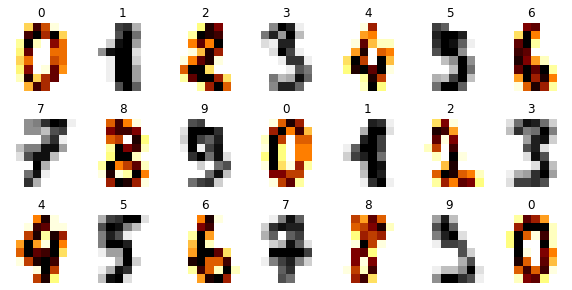

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

In [15]:
model.fit(X_train, y_train)

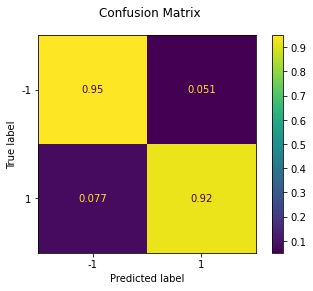

In [16]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [17]:
train_acc, test_acc

(0.9116214335421016, 0.9361111111111111)

In [18]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

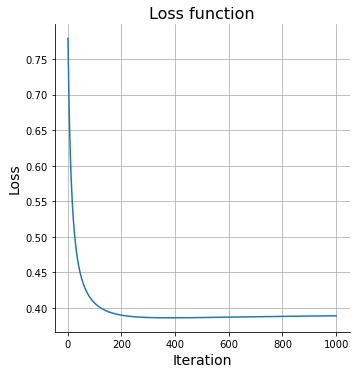

In [19]:
## your code
sns.relplot(x=range(1,1001,1), y=model.loss_[0:1000], kind="line")
plt.title('Loss function', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid()
plt.show();

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

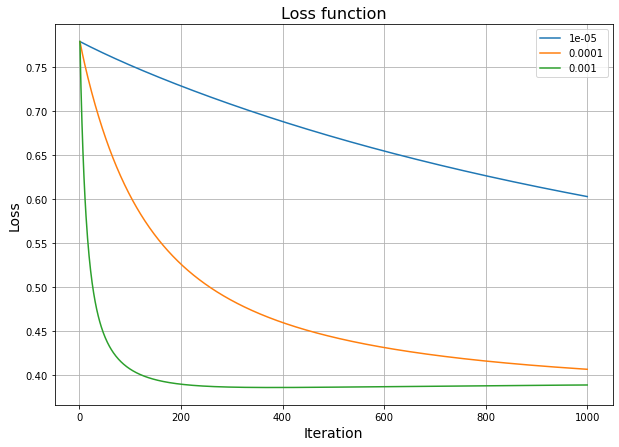

In [20]:
etas = [10**-5,10**-4, 10**-3]
fig, ax = plt.subplots(figsize=(10,7))

for i in etas:
    model_1 = CustomLogisticRegression(eta=i)
    model_1.fit(X_train, y_train)
    ax.plot(range(1,len(model_1.loss_)+1,1), model_1.loss_)
plt.title('Loss function', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend([10**-5,10**-4, 10**-3,0.005])
plt.grid()
plt.show();

The figure shows that with an increase of the parameter learning rate, speed of finding the optimal solution also increases. But this hyperparameter can't be constantly increased, since it is possible to step over the minimum of the los function and the model won't work correctly.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

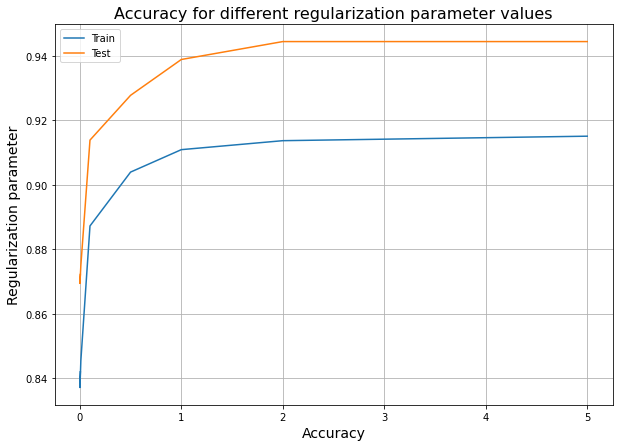

In [21]:
## your code
fig, ax = plt.subplots(figsize=(10,7))
acc_train = []
acc_test = []
C_par = [5*10**-3,10**-3,10**-2,10**-1,0.5,1,2,5]
for i in C_par:
    model_2 = CustomLogisticRegression(C = i)
    model_2.fit(X_train, y_train)
    acc_train.append(metrics.accuracy_score(y_pred=model_2.predict(X_train), y_true=y_train))
    acc_test.append(metrics.accuracy_score(y_pred=model_2.predict(X_test), y_true=y_test))
ax.plot(C_par, acc_train)
ax.plot(C_par, acc_test)
plt.title('Accuracy for different regularization parameter values', fontsize=16)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Regularization parameter', fontsize=14)
plt.legend(['Train','Test'])
plt.grid()
plt.show();

With an increase in the regularization coefficient, the accuracy of the model increases, but the metrics for the test and training samples didn't converge, although both exceed 0.9.

**(0.5 points)** Compare zero initialization and random initialization. 

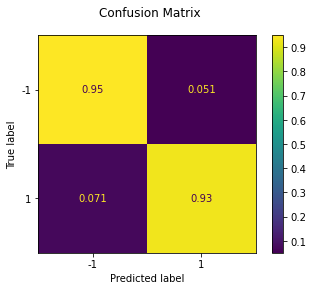

In [22]:
## your code
model_zero = CustomLogisticRegression(zero_init=True)
model_zero.fit(X_train, y_train)
train_acc_zero, test_acc_zero = fit_evaluate(model_zero, X_train, y_train, X_test, y_test)

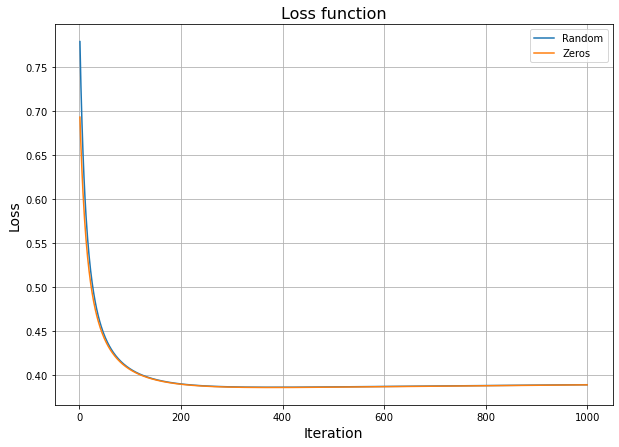

In [23]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(range(1,1001,1), model.loss_[:1000], label = 'Random')
ax.plot(range(1,1001,1), model_zero.loss_[:1000], label = 'Zeros')
plt.title('Loss function', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid()
plt.show();

It was not possible to demonstrate a strong difference between the two options for initializing the weights. The initialization of the weights determines the rate of convergence of gradient descent.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [24]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        aa = np.zeros((len(X),len(Y)))
        for i, row_x in enumerate(X):
            for j, row_y in enumerate(Y):
                aa[i,j] = np.sqrt(sum((X[i]-Y[j])**2))
        return aa
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        a=[]
        for i in self.classes_:
            a.append(np.sum(weights[y==i]))
        return np.array(a)
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(P + self.eps)
            ww=np.zeros((len(X),len(self.classes_) ))
            for i, row in enumerate(P):   
                neighbors = np.concatenate((row.reshape(-1,1), self.y.reshape(-1,1)), axis = 1)
                neighbors_sorted = neighbors[neighbors[:, 0].argsort()]
                k_neighbors = neighbors_sorted[:self.n_neighbors]
                w_neghbor = weights_of_points[i][neighbors[:, 0].argsort()[:self.n_neighbors]]
                k_neighbors_p = self.get_class_weights(k_neighbors[:,1], w_neghbor)
    
                ww[i] = k_neighbors_p / sum(w_neghbor)
        
                       
            return ww
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)

            if self.weights == 'distance':
                weights_of_points = 1/(P + self.eps)
                
            ww=[]
            for i, row in enumerate(P):   
                neighbors = np.concatenate((row.reshape(-1,1), self.y.reshape(-1,1)), axis = 1)
                neighbors_sorted = neighbors[neighbors[:, 0].argsort()]
                k_neighbors = neighbors_sorted[:self.n_neighbors]
                w_neghbor = weights_of_points[i][neighbors[:, 0].argsort()[:self.n_neighbors]]
    
                k_neighbors_p = self.get_class_weights(k_neighbors[:,1], w_neghbor)
    
                
    
                ww.append(self.classes_[(k_neighbors_p / sum(w_neghbor)).argmax()])

            return np.array(ww)
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")  
            
        

In [25]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [26]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [27]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])),np.array([2,4,0]))

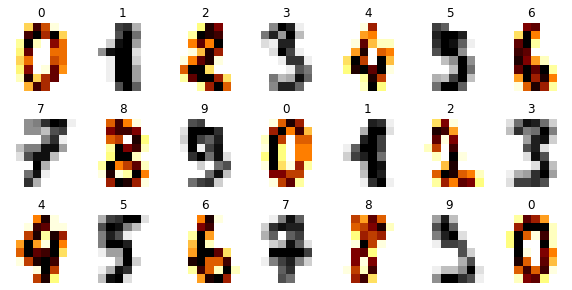

In [28]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [29]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [30]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [31]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

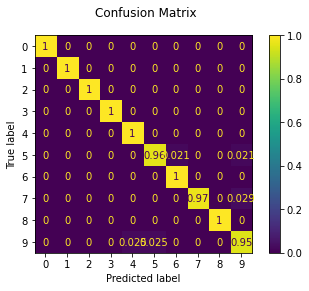

In [32]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [33]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

**Response**: Mispredictions are observed for numbers that are similar in writing, for example, 3 and 5, 5 and 6, 5 and 9. The data presented is handwritten, so their appearance depends on handwriting, writing speed, which adds complexity to classification.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

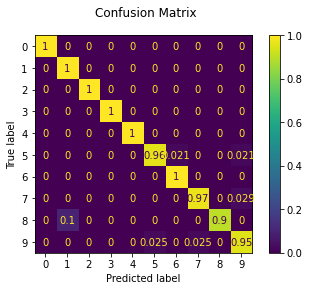

(1.0, 0.9777777777777777)

In [34]:
## your code
model_2 = CustomKNeighborsClassifier(n_neighbors=20, weights='distance')
model_2.fit(X_train, y_train)
train_acc_2, test_acc_2 = fit_evaluate(model_2, X_train, y_train, X_test, y_test)
train_acc_2, test_acc_2


In [35]:
prob = np.zeros((6,len(np.unique(y_train))))
i = 0
for n in range(2,25,4):
    model = CustomKNeighborsClassifier(n_neighbors = n, weights='distance')
    model.fit(X_train, y_train)
    prob[i]=model.predict_proba(X_test)[-2]
    i+=1


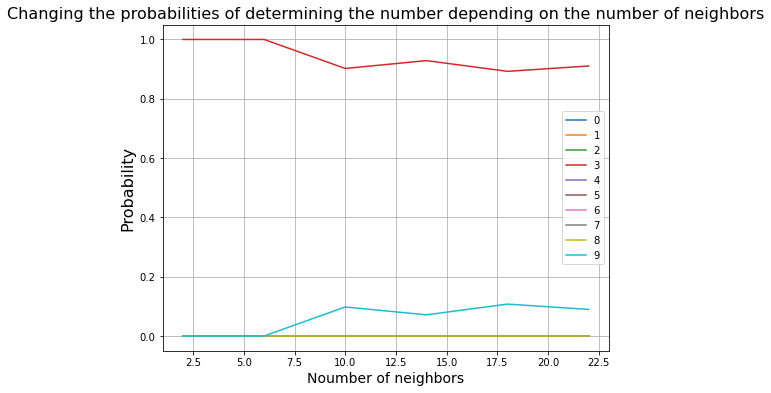

In [36]:
fig, ax = plt.subplots(figsize=(8,6))
for n in range(prob.shape[1]):
    ax.plot(range(2,25,4),prob[:,n])
plt.title('Changing the probabilities of determining the number depending on the number of neighbors', fontsize=16)
plt.xlabel('Noumber of neighbors', fontsize=14)
plt.ylabel('Probability', fontsize=16)
plt.legend(range(0,10,1))
plt.grid()
plt.show()

An example of changing the probability of predicting the number 3 is given. As can be seen from the figure, with an increase in the number of neighbors in the model, the probability decreases for the specified number, and increases for a similar one (in this case, 9). The more points are selected in the neighborhood, the more likely it is that we will come across numbers that are close in appearance.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

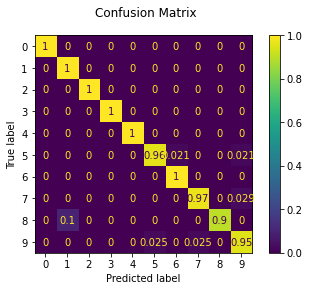

(1.0, 0.9777777777777777)

In [37]:
## your code
model_3 = CustomKNeighborsClassifier(n_neighbors=20, weights='distance')
model_3.fit(X_train, y_train)
train_acc_3, test_acc_3 = fit_evaluate(model_3, X_train, y_train, X_test, y_test)
train_acc_3, test_acc_3

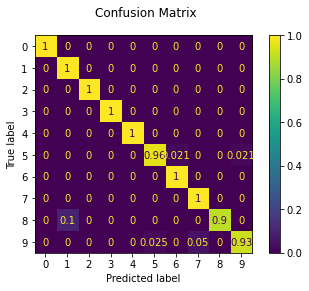

(0.97633959638135, 0.9777777777777777)

In [38]:
## your code
model_4 = CustomKNeighborsClassifier(n_neighbors=20, weights='uniform')
model_4.fit(X_train, y_train)
train_acc_4, test_acc_4 = fit_evaluate(model_4, X_train, y_train, X_test, y_test)
train_acc_4, test_acc_4

Equal weighting doesn't take into account the distance between the new data point and its k-nearest neighbors. They all have the same effect on prediction. Inverse distance weighting assigns higher weights to closer training examples, which should improve prediction accuracy. Rather, it is important in the presence of outliers, incorrect data.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

**Response**: There are many options for calculating the distance between vectors. In addition to the Euclidean distance, you can use the Manhattan distance (it is more resistant to outliers due to the lack of exponentiation and doesn't critically increase the distance between vectors if values differ in one indicator), or cosine (often used in searching for similar texts).
More universal is the Minkowski distance, in which you can change the degree and thus modify the formula. When fitting the degree (can be thought of as a hyperparameter), the formula is converted to Manhattan distance, Euclidean, etc.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

**Response**: Basic version of recommender systems using the calculation of the cosine of the angle between vectors (recommendation of products, books, films)

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [39]:
PATH = "./data/"

In [40]:
data = pd.read_csv('train.csv').set_index('PassengerId')
data_test = pd.read_csv('test.csv').set_index('PassengerId')
sample_submission = pd.read_csv('sample_submission.csv')

In [41]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [42]:
## your code
data.columns = data.columns.str.lower()
data_test.columns = data_test.columns.str.lower()

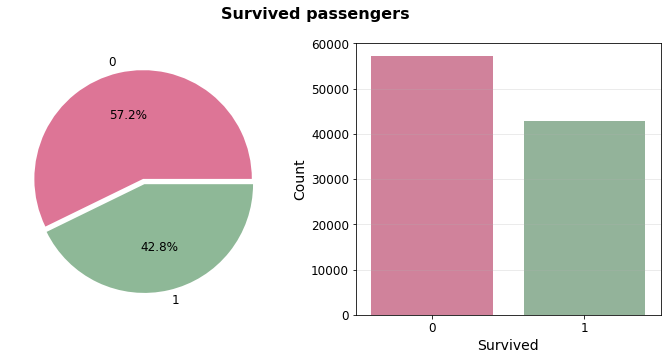

In [43]:
colors = ['#DD7596', '#8EB897']
color_palette = sns.color_palette(colors)
f,ax = plt.subplots(1,2,figsize=(12,5))
plt.suptitle('Survived passengers', fontsize = 16, fontweight = 'bold')
data['survived'].value_counts().plot.pie(explode=[0,0.05],autopct='%1.1f%%', textprops={'fontsize': 12}, 
                                       ax=ax[0], colors = colors)
ax[0].set_ylabel('')

sns.countplot('survived',data=data,ax=ax[1],palette = color_palette)
ax[1].tick_params(labelsize=12)
ax[1].set_xlabel('Survived', fontsize = 14)
ax[1].set_ylabel('Count', fontsize = 14)
ax[1].grid(axis = 'y', alpha = 0.3)
plt.show()

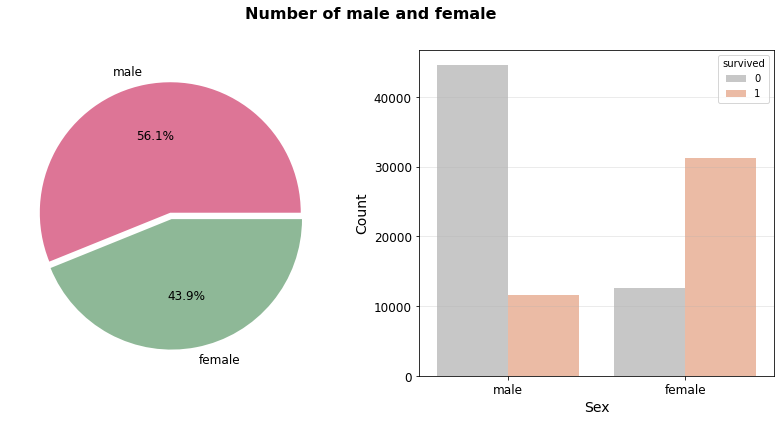

In [44]:
f,ax=plt.subplots(1,2,figsize=(14,6))
plt.suptitle('Number of male and female', fontsize = 16, fontweight = 'bold')
data['sex'].value_counts().plot.pie(explode=[0,0.05],autopct='%1.1f%%',textprops={'fontsize': 12},ax=ax[0], colors = colors)

ax[0].set_ylabel('')
sns.countplot('sex',data=data,hue='survived',ax=ax[1],palette = random.choice(COLOR))
ax[1].tick_params(labelsize=12)
ax[1].set_xlabel('Sex', fontsize = 14)
ax[1].set_ylabel('Count', fontsize = 14)
ax[1].grid(axis = 'y', alpha = 0.3)
plt.show()

There were more men than women on the ship, but the difference was not overwhelming. After the crash, more passengers died than survived. At the same time, many more men died than women (most likely for procreation).

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

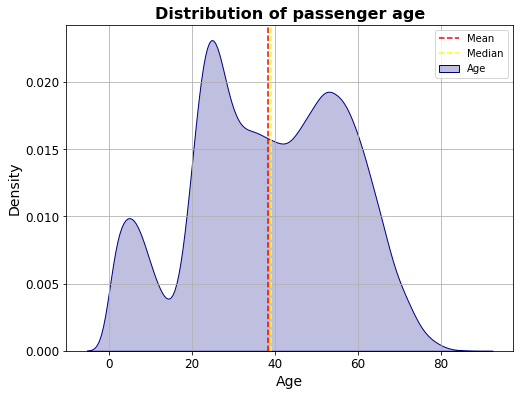

In [45]:
## your code
f, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(data['age'], color='navy', shade=True)
ax.axvline(x=data['age'].mean(),linestyle = '--', color = 'red', label = 'Mean')
ax.axvline(x=data['age'].median(),linestyle = '--', color = 'yellow', label = 'Median')
ax.set_xlabel(('age').capitalize(), fontsize = 14)
ax.set_ylabel('Density', fontsize = 14)
ax.tick_params(labelsize=12)
plt.title('Distribution of passenger age', fontsize = 16,fontweight = 'bold')
plt.legend(['Mean','Median',('age').capitalize()])
plt.grid()
plt.show()

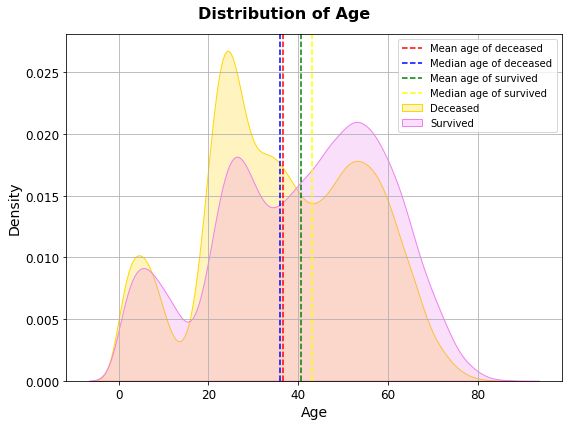

In [46]:
f, ax = plt.subplots(figsize=(8, 6))
plt.suptitle('Distribution of Age', fontsize = 16, fontweight = 'bold')
sns.kdeplot(data.loc[data['survived'] == 0, 'age'], color='gold', shade=True, ax=ax, label = 'Deceased')
ax.axvline(x=data[data['survived'] == 0]['age'].mean(),linestyle = '--', color = 'red', label = 'Mean age of deceased')
ax.axvline(x=data[data['survived'] == 0]['age'].median(),linestyle = '--', color = 'blue', label = 'Median age of deceased')
sns.kdeplot(data.loc[data['survived'] == 1, 'age'], color='violet',shade=True, ax=ax, label = 'Survived')
ax.axvline(x=data[data['survived'] == 1]['age'].mean(),linestyle = '--', color = 'green', label = 'Mean age of survived')
ax.axvline(x=data[data['survived'] == 1]['age'].median(),linestyle = '--', color = 'yellow', label = 'Median age of survived')
ax.set_xlabel('Age', fontsize = 14)
ax.set_ylabel('Density', fontsize = 14)
ax.legend()
ax.grid()
ax.tick_params(labelsize=12)
    
plt.tight_layout()
plt.show()

In [47]:
res_all = np.array([['All passengers', round(data['age'].mean(),1), round(data['age'].median(),3)], 
                       ['Survived', round(data[data['survived'] == 1]['age'].mean(),1), round(data[data['survived'] == 1]['age'].median(),3)],
                    ['Deceased', round(data[data['survived'] == 0]['age'].mean(),1), round(data[data['survived'] == 0]['age'].median(),3)]])
result_all = pd.DataFrame(res_all,columns = ['model','Mean', 'Median'])
result_all

,model,Mean,Median
0,All passengers,38.4,39.0
1,Survived,40.6,43.0
2,Deceased,36.7,36.0


The average and median age of all passengers are close and are 39 years.
At the same time, the distribution of survivors and deceased differs. There are more young people among the dead, and older people among the survivors. Most likely, this can be explained by the affluence of passengers and, accordingly,  class of tickets purchased, which should be considered.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

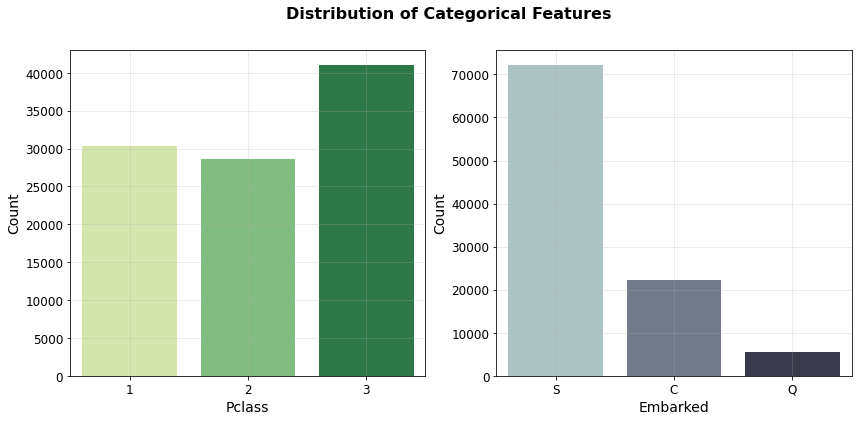

In [48]:
## your code
cat_col = ['pclass','embarked']
num_rows, num_cols = 1,2
fig, ax = plt.subplots(num_rows, num_cols, figsize = (14,6))
plt.suptitle('Distribution of Categorical Features', fontsize = 16, fontweight = 'bold')
for index, column in enumerate(data[cat_col].columns):
    j = (index % num_cols)
    sns.countplot(x = column, data = data, palette = random.choice(COLOR), ax=ax[j])
    ax[j].grid(alpha = 0.3)
    ax[j].tick_params(labelsize=12)
    ax[j].set_xlabel(column.capitalize(), fontsize=14)
    ax[j].set_ylabel('Count', fontsize=14)
    
plt.show()

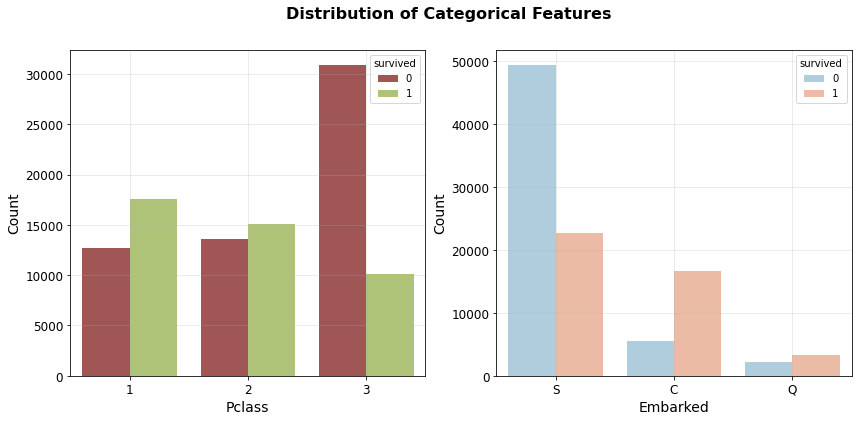

In [49]:
cat_col = ['pclass','embarked']
num_rows, num_cols = 1,2
fig, ax = plt.subplots(num_rows, num_cols, figsize = (14,6))
plt.suptitle('Distribution of Categorical Features', fontsize = 16, fontweight = 'bold')
for index, column in enumerate(data[cat_col].columns):
    j = (index % num_cols)
    sns.countplot(x = column, hue = 'survived', data = data, palette = random.choice(COLOR), ax=ax[j])
    ax[j].grid(alpha = 0.3)
    ax[j].tick_params(labelsize=12)
    ax[j].set_xlabel(column.capitalize(), fontsize=14)
    ax[j].set_ylabel('Count', fontsize=14)
plt.show()

Most passengers traveled in third class (the cheapest tickets), passengers in 1st and 2nd class were approximately the same. At the same time, more 3rd class passengers died. Those can be explained by the fact that, first of all, the wealthier people, also women and children, were saved. And in the third class
there was a majority of men.
Most of the passengers landed at Southampton, so most of the passengers who died were from the above port. In two other cases, there were more survivors.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [50]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
survived,100000.0,NaN,NaN,NaN,0.42774,0.494753,0.0,0.0,0.0,1.0,1.0
pclass,100000.0,NaN,NaN,NaN,2.10691,0.837727,1.0,1.0,2.0,3.0,3.0
name,100000,92144,"Johnson, John",31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,100000,2,male,56114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,96708.0,NaN,NaN,NaN,38.355472,18.313556,0.08,25.0,39.0,53.0,87.0
sibsp,100000.0,NaN,NaN,NaN,0.39769,0.862566,0.0,0.0,0.0,1.0,8.0
parch,100000.0,NaN,NaN,NaN,0.45456,0.950076,0.0,0.0,0.0,1.0,9.0
ticket,95377,75331,A/5,602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fare,99866.0,NaN,NaN,NaN,43.92933,69.58882,0.68,10.04,24.46,33.5,744.66
cabin,32134,26992,C19828,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


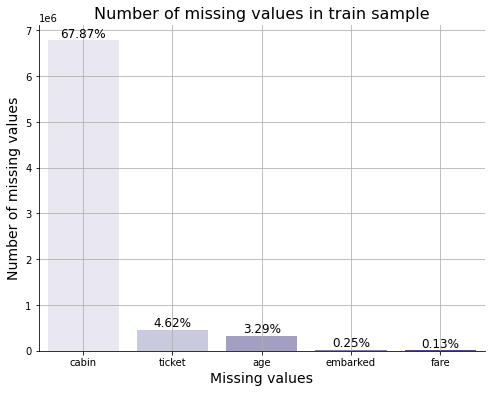

In [51]:
## your code
data_null = data.isna().sum().sort_values(ascending=False)
null_plot = data_null[data_null>0]*100
f, ax = plt.subplots(figsize=(8, 6))
sns.despine(f)
sns.barplot(null_plot.index, null_plot, palette = random.choice(COLOR))
plt.grid()
plt.title('Number of missing values in train sample', fontsize=16)
plt.xlabel('Missing values', fontsize=14)
plt.ylabel('Number of missing values', fontsize=14)
for i, val in enumerate(data.isna().mean().sort_values(ascending=False)*100):
    if val > 0:
        plt.text(i, null_plot.iloc[i], str(round(val,2))+'%', horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.show()

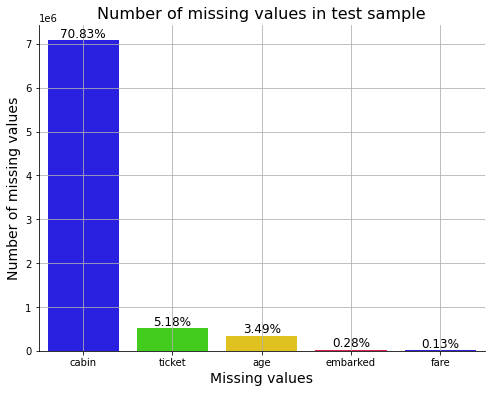

In [52]:
## your code
data_null_test = data_test.isna().sum().sort_values(ascending=False)
null_plot_test = data_null_test[data_null_test>0]*100
f, ax = plt.subplots(figsize=(8, 6))
sns.despine(f)
sns.barplot(null_plot_test.index, null_plot_test, palette = random.choice(COLOR))
plt.grid()
plt.title('Number of missing values in test sample', fontsize=16)
plt.xlabel('Missing values', fontsize=14)
plt.ylabel('Number of missing values', fontsize=14)
for i, val in enumerate(data_test.isna().mean().sort_values(ascending=False)*100):
    if val > 0:
        plt.text(i, null_plot_test.iloc[i], str(round(val,2))+'%', horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.show()

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

**Response**: 
- Almost 70% of the data is missing in the feature *cabine*. There are two options: remove this feature or fill in the missing data with the value "unknown", and in the rest, for example, highlight the initial letters.
- *Tickets* have different names, but the first letters of the ticket series can be distinguished from them. This characteristic can be filled, for example, with the most frequent value depending on another feature, such as *fare* or *class*. Since the missing values are less than 5%, the result should not be particularly affected.
- Numerical features of *age* and *fare* can be filled either with the average (median) value, also depending on another feature, or these lines can be deleted, since their number is very small.
- A categorical feature *embarked* can be filled in with the most frequent value or completely deleted, since their number is too small.

Any filling in of missing values will result in data misrepresentation. Therefore, if there are many missing values, then experiments should be carried out with filling in the missing data or deleting them, and then with training the model and checking on the validation set.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [53]:
def spl_tick(x):
    """Extracting letters from tickets"""
    return x.split()[0] if x.isdigit() == False else 'X'
def re_symb(x):
    """Removing symbols"""
    return re.sub(r"[#%!@*.,!:;]", "", x)

In [54]:
def fam(x):
    """Simplifying the number of family members"""
    if x<2:
        return 0
    elif x < 3:
        return 1
    elif x > 5:
        return 3
    else:
        return 2

In [55]:
def missing_data(data):
    """Filling in Missing Values"""
    data['embarked'] = data['embarked'].fillna(data['embarked'].mode()[0])
    fare_map = data[['fare', 'pclass']].dropna().groupby('pclass').median().to_dict()    
    data['fare'] = data['fare'].fillna(data['pclass'].map(fare_map['fare']))
    fare_map = data[['age', 'pclass']].dropna().groupby('pclass').median().to_dict()    
    data['age'] = data['age'].fillna(data['pclass'].map(fare_map['age']))
    data['ticket'] = data['ticket'].fillna('X')
    data['embarked'] = data['embarked'].fillna('No')
    data['cabin'] = data['cabin'].fillna('_')
    return data

In [56]:
def feature_eng(data):
    """Feature engineering"""
    data['ticket'] = data['ticket'].apply(spl_tick).apply(re_symb)
    data['family'] = data['sibsp'] + data['parch'] + 1
    data['family'] = data['family'].apply(lambda x: fam(x))
    return data

In [57]:
def standsc(x_train, x_val, x_test):
    """Standardization"""
    stsc = StandardScaler()
    x_train = stsc.fit_transform(x_train)
    x_val = stsc.transform(x_val)
    x_test = stsc.transform(x_test)
    return x_train, x_val, x_test

The functions above have been created to simplify repetitive actions.

In [58]:
## your code
df_fill = data.copy()
df_fill_test = data_test.copy()

In [59]:
df_fill = missing_data(df_fill)
df_fill_test = missing_data(df_fill_test)

In [60]:
df_fill_en = feature_eng(df_fill)
df_fill_test_en = feature_eng(df_fill_test)

Missing values are filled in (numeric values are filled with the median depending on the class, and categorical ones are filled with an additional unkown character), new features are created (the letters in the tickets are displayed, features *sissp* and *parch* are combined).

In [61]:
df_fill_en.columns

Index(['survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'family'],
      dtype='object')

In [62]:
col_drop = ['name', 'sibsp', 'parch', 'cabin']

In [63]:
target = df_fill_en['survived']
feature = df_fill_en.drop(['survived'] + col_drop, axis=1)
x_test = df_fill_test_en.drop(col_drop, axis=1)

In [64]:
x_train, x_val, y_train, y_val = train_test_split(feature, target, test_size = 0.3, stratify = target, random_state = 42)

In [65]:
x_train.shape, x_val.shape, y_train.shape, x_val.shape

((70000, 7), (30000, 7), (70000,), (30000, 7))

The main sample is divided into train and test.

In [66]:
cat_сols = [col for col in feature.columns if (feature[col].dtype=="O") and (col!= 'ticket')]
cat_сols

['sex', 'embarked']

In [67]:
le = LabelEncoder()
x_train['ticket'] = le.fit_transform(x_train['ticket'])
x_val['ticket'] = le.transform(x_val['ticket'])
x_test['ticket'] = le.transform(x_test['ticket'])

In [68]:
x_train = x_train.join(pd.get_dummies(x_train[cat_сols]))
x_val= x_val.join(pd.get_dummies(x_val[cat_сols]))
x_test = x_test.join(pd.get_dummies(x_test[cat_сols]))

The feature *ticket* (first letters) is converted with LabelEncoder, because it has a large range of values. The remaining categorical features are transformed using OneHotEncoder.

In [69]:
col_sc = ['ticket','fare','age']

In [70]:
x_train[col_sc], x_val[col_sc], x_test[col_sc] = standsc(x_train[col_sc], x_val[col_sc], x_test[col_sc])

In [71]:
col_drop = ['sex','embarked']

In [72]:
x_train_d = x_train.drop(col_drop,axis=1)
x_val_d = x_val.drop(col_drop,axis=1)
x_test_d = x_test.drop(col_drop,axis=1)

Got rid of all the features that were converted and are no longer needed.

In [73]:
lr = LogisticRegression()

In [74]:
param_0 = {
    'tol' : [0.00001],
    'random_state' : [42],
     }

In [75]:
gr = GridSearchCV(lr,param_0, refit=True, scoring = 'accuracy', cv=5)
best_model = gr.fit(x_train_d,y_train)
prediction = best_model.predict(x_val_d)
print(best_model.best_params_)

{'random_state': 42, 'tol': 1e-05}


Training with little or no use of hyperparameters and using cross-validation witj k-fold=5.

In [76]:
round(accuracy_score(prediction,y_val),3)

0.767

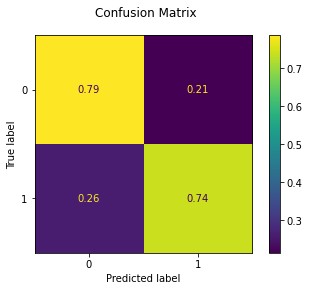

In [77]:
disp = metrics.plot_confusion_matrix(best_model, x_val_d, y_val, normalize='true')
disp.figure_.suptitle("Confusion Matrix");

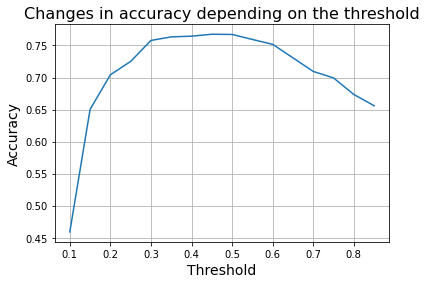

In [78]:
ac = []
for tr in np.arange(0.1, 0.9, 0.05):
    pr = best_model.predict_proba(x_val_d)[:,1]
    ac.append(accuracy_score(np.where(pr>=tr,1,0),y_val))
plt.plot(np.arange(0.1, 0.9, 0.05),ac)
plt.xlabel('Threshold', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.title('Changes in accuracy depending on the threshold', fontsize = 16)
plt.grid()
plt.show()

In [79]:
np.arange(0.1, 0.9, 0.05)[ac.index(max(ac))]

0.45000000000000007

In [80]:
round(max(ac),3)

0.768

The accuracy of the model was 0.768 with a threshold of 0.45.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [81]:
def adge_conv(x):
    """Separation of the passenger by age categories"""
    if x<18:
        return 0
    elif x < 35:
        return 1
    elif x > 60:
        return 3
    else:
        return 2

In [82]:
def feature_eng_best(data):
    data['fare_log'] = data['fare'].apply(lambda x: np.log(1+x))
    data['cabintype'] = data['cabin'].apply(lambda x:x[0])
    data['ticket'] = data['ticket'].apply(spl_tick).apply(re_symb)
    data['family'] = data['sibsp'] + data['parch'] + 1
    data['family'] = data['family'].apply(lambda x: fam(x))
    data['agelev'] = data['age'].apply(lambda x: adge_conv(x))
    return data

In [83]:
df_fill_en = feature_eng_best(df_fill)
df_fill_test_en = feature_eng_best(df_fill_test)

Additionally, the passage is given to a logarithmic form, the first letters of the cabin names are highlighted, the age of passengers is divided into categories. Further, the same actions are performed as in the preparation of data and training of the model in the previous part.

In [84]:
col_drop = ['name','age', 'sibsp', 'parch','fare', 'cabin']

In [85]:
target = df_fill_en['survived']
feature = df_fill_en.drop(['survived'] + col_drop, axis=1)
x_test = df_fill_test_en.drop(col_drop, axis=1)

In [86]:
x_train, x_val, y_train, y_val = train_test_split(feature, target, test_size = 0.3, stratify = target, random_state = 42)

In [87]:
cat_сols = [col for col in feature.columns if (feature[col].dtype=="O") and (col!= 'ticket')]
cat_сols

['sex', 'embarked', 'cabintype']

In [88]:
le = LabelEncoder()
x_train['ticket'] = le.fit_transform(x_train['ticket'])
x_val['ticket'] = le.transform(x_val['ticket'])
x_test['ticket'] = le.transform(x_test['ticket'])

In [89]:
x_train = x_train.join(pd.get_dummies(x_train[cat_сols]))
x_val= x_val.join(pd.get_dummies(x_val[cat_сols]))
x_test = x_test.join(pd.get_dummies(x_test[cat_сols]))

In [90]:
col_sc = ['ticket','fare_log']

In [91]:
x_train[col_sc], x_val[col_sc], x_test[col_sc] = standsc(x_train[col_sc], x_val[col_sc], x_test[col_sc])

In [92]:
col_drop = ['sex','embarked','cabintype']

In [93]:
x_train_d = x_train.drop(col_drop,axis=1)
x_val_d = x_val.drop(col_drop,axis=1)
x_test_d = x_test.drop(col_drop,axis=1)

In [94]:
## your code
param = {
    'penalty' : ['l1','l2','elasticnet'],
    'C': [0.0001,0.01,0.1],
    'tol' : [0.00001],
    'random_state' : [42],
    'max_iter': [5000,15000, 30000]
     }

In [95]:
lr = LogisticRegression()
gr = GridSearchCV(lr,param, refit=True, scoring = 'accuracy', cv=5)
best_model = gr.fit(x_train_d,y_train)
prediction = best_model.predict(x_val_d)
print(best_model.best_params_)

{'C': 0.1, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'tol': 1e-05}


In [96]:
round(accuracy_score(prediction,y_val),3)

0.774

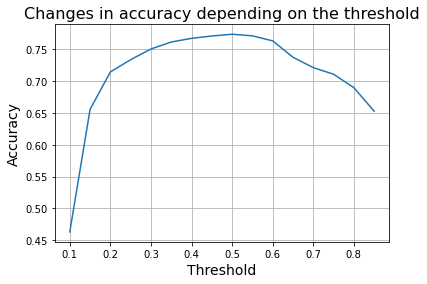

In [97]:
ac = []
for tr in np.arange(0.1, 0.9, 0.05):
    pr = best_model.predict_proba(x_val_d)[:,1]
    ac.append(accuracy_score(np.where(pr>=tr,1,0),y_val))
plt.plot(np.arange(0.1, 0.9, 0.05),ac)
plt.xlabel('Threshold', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.title('Changes in accuracy depending on the threshold', fontsize = 16)
plt.grid()
plt.show()

As you can see, the accuracy metric has improved. For this model, a prediction will be made for the test sample.

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [98]:
sample_submission['Survived'] = best_model.predict(x_test_d)


In [99]:
sample_submission.to_csv('result.csv',index=False)

In [100]:
sample_submission.head()

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1





[![Screenshot](Screenshot_1.jpg)](https://prnt.sc/bz0fr8_FpdWn)